<a href="https://colab.research.google.com/github/crnbaker/MONAI/blob/hilbert-performance/monai_envelope_detection_performance.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Run this cell to create timing functions

In [15]:
import torch
import time
import numpy as np


class Timer:
    def __init__(self, n_iterations, cuda=True):
        self.n_iterations = n_iterations
        self.cuda = cuda
        self.timings = []

    def time(self, func):
        def timed(*args):
            for n in range(self.n_iterations):
                if self.cuda:
                    t1 = torch.cuda.Event(enable_timing=True)
                    t2 = torch.cuda.Event(enable_timing=True)
                    t1.record()
                else:
                    t1 = time.time()

                result = func(*args)

                if self.cuda:
                    t2.record()
                    torch.cuda.synchronize()
                    elapsed = t1.elapsed_time(t2)
                else:
                    elapsed = (time.time() - t1) * 1e3
                self.timings.append(elapsed)
            return result
        return timed


class ParameterSweeper:
    def __init__(self, n_iterations, cuda=True):
        self.timings = []
        self.cuda = cuda
        self.n_iterations = n_iterations

    def sweep(self, func):
        def swept(*arglists):
            # Check same number of each argument
            if len(set([len(arglist) for arglist in arglists])) > 1:
                raise ValueError('Same number of each argument must be provided to ParameterScanner')
            N_test_value_sets = len(arglists[0])
            N_arguments = len(arglists)
            results = []

            for n in range(N_test_value_sets):
                timer = Timer(self.n_iterations, self.cuda)
                args = [arglists[i][n] for i in range(N_arguments)]
                results.append(timer.time(func)(*args))
                self.timings.append(np.min(timer.timings))
            return results
        return swept


Run this cell to install MONAI from the feature branch

In [2]:
!pip install pip install git+https://github.com/crnbaker/MONAI.git@1210-hilbert-transform

  Cloning https://github.com/crnbaker/MONAI.git (to revision 1210-hilbert-transform) to /tmp/pip-req-build-_w1uov03
  Running command git clone -q https://github.com/crnbaker/MONAI.git /tmp/pip-req-build-_w1uov03
  Running command git checkout -b 1210-hilbert-transform --track origin/1210-hilbert-transform
  Switched to a new branch '1210-hilbert-transform'
  Branch '1210-hilbert-transform' set up to track remote branch '1210-hilbert-transform' from 'origin'.
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
    Preparing wheel metadata ... done
  Created wheel for monai: filename=monai-0.3.0+90.g026b0fe-cp36-none-any.whl size=328565 sha256=544842a25ae65947e381ee9a867ea8fb0b045f3e293e26cb3c4dab142b1c0b7e
  Stored in directory: /tmp/pip-ephem-wheel-cache-ds5swqsn/wheels/a1/c4/a8/9c3f88b7071b17f05ee3b290a07c8f4661b11321642053988e
Successfully built monai


Run this cell to import dependencies

In [17]:
from monai.transforms import DetectEnvelope
from monai.networks.layers import HilbertTransform
import matplotlib.pyplot as plt
import torch
import numpy as np
import scipy.signal as sig

Run this cell to test the performance of the new MONAI Hilbert Transform and Envelope Detection features on the GPU and CPU, compared to SciPy.

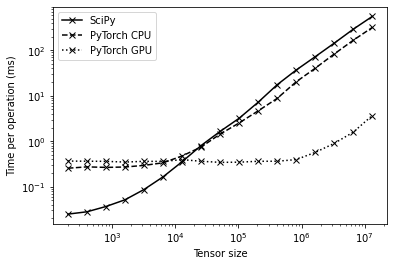

In [20]:
# Simple function to create a simulate ultrasound pulse
def us_pulse(f, d, fs):

    t = np.linspace(0, d, int(np.floor(d * fs)))
    w1 = sig.hann(len(t))
    w2 = np.linspace(1.0, 0.0, len(t)) ** 6.0
    x = np.sin(2 * np.pi * f * t) * w1 * w2

    return t, x

# Number of times to repeat test for each input array size (minimum time taken will be recorded)
n_iterations = 5
# Sample rate used to create ultrasound pulse
fs = 10e6
# Number of signals to stack up into a 2D array for each test input
n_sigs_per_test = 50

plt.figure()
device = torch.device('cuda')

# Signal lengths to test (powers of two)
signal_lengths = [2 ** (x + 2) for x in range(17)]

# Create test data sets (2D stacks of simulated ultrasound signals)
numpy_2D_test_signals = [np.stack(
    [us_pulse(3.2e6, sl / fs, fs)[1] * a for a in range(n_sigs_per_test)]
) for sl in signal_lengths]

torch_2D_test_signals = [torch.as_tensor(np.ascontiguousarray(np.stack(
    [us_pulse(3.2e6, sl / fs, fs)[1] * a for a in range(n_sigs_per_test)]
)), device=device).unsqueeze(0) for sl in signal_lengths]

# Run parameter sweep on Scipy function using Numpy arrays
sweeper_scipy = ParameterSweeper(n_iterations, cuda=False)
results = sweeper_scipy.sweep(sig.hilbert)(
    numpy_2D_test_signals,
    [None] * len(numpy_2D_test_signals),
    [0] * len(numpy_2D_test_signals)
)
plt.loglog(np.array(signal_lengths) * 50, sweeper_scipy.timings, 'kx-', label='SciPy')

# Run parameter sweep on MONAI transform using Numpy arrays
sweeper_monai_cpu = ParameterSweeper(n_iterations, cuda=False)
results = sweeper_monai_cpu.sweep(DetectEnvelope(axis=0))(
    numpy_2D_test_signals
)
plt.loglog(
    np.array(signal_lengths) * n_sigs_per_test,
    sweeper_monai_cpu.timings, 'kx--',
    label='MONAI CPU'
    )

# Run parameter sweep on MONAI layer using PyTorch Tensors (on CUDA)
sweeper_monai_gpu = ParameterSweeper(n_iterations, cuda=True)
results = sweeper_monai_gpu.sweep(HilbertTransform())(
    torch_2D_test_signals,
)
plt.loglog(
    np.array(signal_lengths) * n_sigs_per_test,
    sweeper_monai_gpu.timings,
    'kx:', label='MONAI GPU'
    )

plt.xlabel('Tensor size')
plt.ylabel('Time per operation (ms)')
plt.legend()
plt.show()

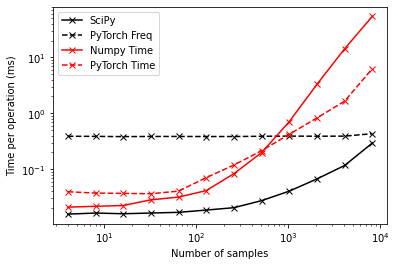

In [ ]:
import matplotlib.pyplot as plt
import torch
import numpy as np
import scipy.signal as sig

# Set torch device to GPU
device = torch.device('cuda')

# Number of times to run operation at each point of the sweep.
# Fastest time is recorded.
n_iterations = 10

# Signal lengths (samples) to scan (powers of 2)
signal_lengths = [2 ** (x + 2) for x in range(12)]
fs = 10e6 # sample rate (Hz)

# Create set of test signals (Numpy arrays)
np_test_signals = [
                cb_hilbert.us_pulse(3.2e6, sl / fs, fs)[1]
                for sl in signal_lengths
                ]

# Create set of test signals (PyTorch Tensors on GPU)
torch_test_signals = [
                torch.as_tensor(np.ascontiguousarray(
                        cb_hilbert.us_pulse(3.2e6, sl / fs, fs)[1]
                        ), device=device)
                for sl in signal_lengths
                ]

# Run parameter sweep on Scipy function using Numpy arrays
sweeper = cb_timing.ParameterSweeper(n_iterations, cuda=False)
results = sweeper.sweep(sig.hilbert)(np_test_signals)
plt.loglog(signal_lengths, sweeper.timings, 'kx-', label='SciPy')

# Run parameter sweep on PyTorch frequency domain hilbert using Tensors
sweeper = cb_timing.ParameterSweeper(n_iterations, cuda=True)
results = sweeper.sweep(cb_hilbert.torch_hilbert_f_domain)(torch_test_signals)
plt.loglog(signal_lengths, sweeper.timings, 'kx--', label='PyTorch Freq')

# Run parameter sweep on PyTorch frequency domain hilbert using Tensors
sweeper = cb_timing.ParameterSweeper(n_iterations, cuda=False)
results = sweeper.sweep(cb_hilbert.numpy_hilbert_t_domain)(np_test_signals)
plt.loglog(signal_lengths, sweeper.timings, 'rx-', label='Numpy Time')

# Run parameter sweep in PyTorch time comain hilbert using Tensors
sweeper = cb_timing.ParameterSweeper(n_iterations, cuda=True)
ht_objects = [cb_hilbert.TorchHilbertTimeDomain(signal) for signal in torch_test_signals]
execution_func = lambda ht_obj: ht_obj.execute()
sweeper.sweep(execution_func)(ht_objects)
plt.loglog(signal_lengths, sweeper.timings, 'rx--', label='PyTorch Time')

plt.xlabel('Number of samples')
plt.ylabel('Time per operation (ms)')
plt.legend()


Text(0.5, 0, 'Tensor size')

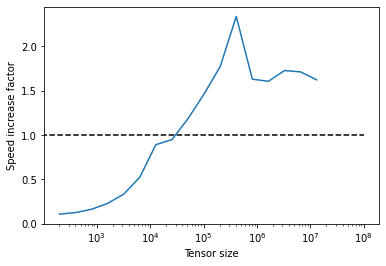

In [ ]:
plt.semilogx(np.array(signal_lengths) * 50, np.array(sweeper5.timings) / np.array(sweeper6.timings))
plt.hlines(1, 0, 10**8, linestyles='--')
plt.ylabel('Speed increase factor')
plt.xlabel('Tensor size')